In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re

In [2]:
import warnings
warnings.filterwarnings('ignore')
import nltk
from nltk.tokenize import word_tokenize
from collections import Counter
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)

True

In [35]:
from keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import EarlyStopping

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

In [5]:
dataset = pd.read_csv('text.csv')

In [6]:
dataset

,Unnamed: 0,text,label
0,0,i just feel really helpless and heavy hearted,4
1,1,ive enjoyed being able to slouch about relax a...,0
2,2,i gave up my internship with the dmrg and am f...,4
3,3,i dont know i feel so lost,0
4,4,i am a kindergarten teacher and i am thoroughl...,4
...,...,...,...
416804,416804,i feel like telling these horny devils to find...,2
416805,416805,i began to realize that when i was feeling agi...,3
416806,416806,i feel very curious be why previous early dawn...,5
416807,416807,i feel that becuase of the tyranical nature of...,3


In [7]:
dataset.drop(columns='Unnamed: 0', inplace=True)

In [8]:
dataset.duplicated().sum()
dataset = dataset.drop_duplicates()

In [9]:
emotion_map = {
    0: 'sadness',
    1: 'joy',
    2: 'love',
    3: 'anger',
    4: 'fear',
    5: 'surprise'
}

dataset['label'] = dataset['label'].map(emotion_map)

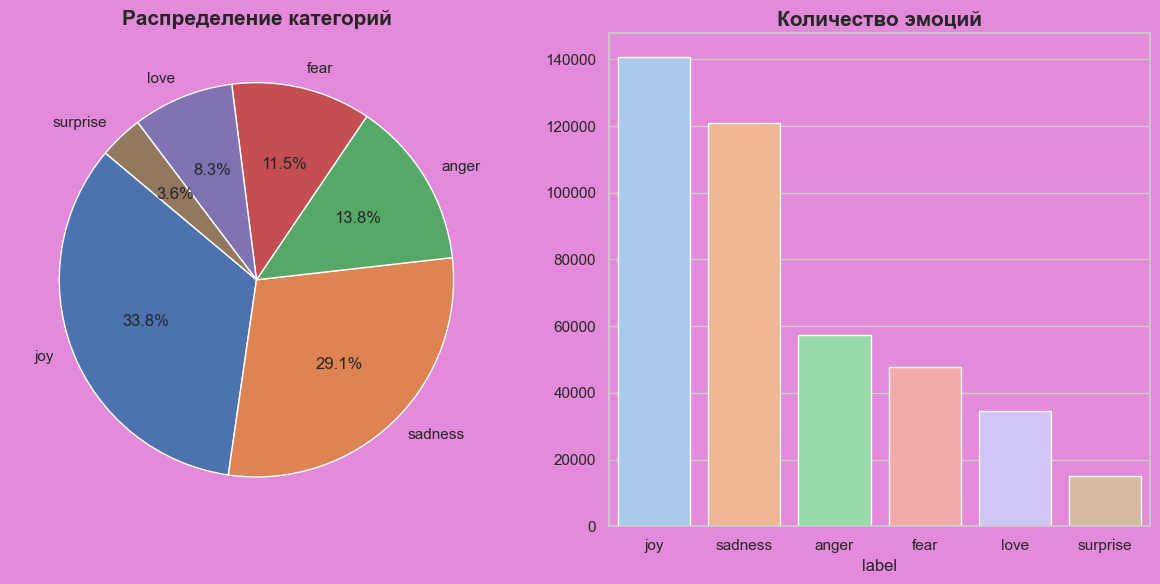

In [10]:
count = dataset['label'].value_counts()
background_color = '#e38ada'
sns.set_theme(style="whitegrid", rc={"axes.facecolor": background_color, 'figure.facecolor': background_color})
fig, axs = plt.subplots(1, 2, figsize=(12, 6), facecolor=background_color)
palette = sns.color_palette("pastel", len(count))
sns.set_palette(palette)
axs[0].pie(count, labels=count.index, autopct='%1.1f%%', startangle=140)
axs[0].set_title('Распределение категорий', fontsize=15, fontweight='bold')
sns.barplot(x=count.index, y=count.values, ax=axs[1], palette=palette)
axs[1].set_title('Количество эмоций', fontsize=15, fontweight='bold')
plt.tight_layout()

plt.show()

Занимаемся предобработкой данных
1. Удаляем URL сайтов

In [11]:
ds = pd.read_csv('text.csv')
ds.drop(columns='Unnamed: 0', inplace=True)
ds.duplicated().sum()
ds = ds.drop_duplicates()

In [12]:
ds

,text,label
0,i just feel really helpless and heavy hearted,4
1,ive enjoyed being able to slouch about relax a...,0
2,i gave up my internship with the dmrg and am f...,4
3,i dont know i feel so lost,0
4,i am a kindergarten teacher and i am thoroughl...,4
...,...,...
416804,i feel like telling these horny devils to find...,2
416805,i began to realize that when i was feeling agi...,3
416806,i feel very curious be why previous early dawn...,5
416807,i feel that becuase of the tyranical nature of...,3


In [13]:
ds['text'] = ds['text'].str.replace(r'http\S+', '', regex=True)
print(ds.head())

                                                text  label
0      i just feel really helpless and heavy hearted      4
1  ive enjoyed being able to slouch about relax a...      0
2  i gave up my internship with the dmrg and am f...      4
3                         i dont know i feel so lost      0
4  i am a kindergarten teacher and i am thoroughl...      4


In [14]:
ds['text'] = ds['text'].str.replace(r'[^\w\s]', '', regex=True)
print(ds.head())

                                                text  label
0      i just feel really helpless and heavy hearted      4
1  ive enjoyed being able to slouch about relax a...      0
2  i gave up my internship with the dmrg and am f...      4
3                         i dont know i feel so lost      0
4  i am a kindergarten teacher and i am thoroughl...      4


In [15]:
ds['text'] = ds['text'].str.replace(r'\s+', ' ', regex=True)
print(ds.head())

                                                text  label
0      i just feel really helpless and heavy hearted      4
1  ive enjoyed being able to slouch about relax a...      0
2  i gave up my internship with the dmrg and am f...      4
3                         i dont know i feel so lost      0
4  i am a kindergarten teacher and i am thoroughl...      4


In [16]:
ds['text'] = ds['text'].str.replace(r'\d+', '', regex=True)
ds.head()

,text,label
0,i just feel really helpless and heavy hearted,4
1,ive enjoyed being able to slouch about relax a...,0
2,i gave up my internship with the dmrg and am f...,4
3,i dont know i feel so lost,0
4,i am a kindergarten teacher and i am thoroughl...,4


In [17]:
ds['text'] = ds['text'].str.lower()
print(ds.head())

                                                text  label
0      i just feel really helpless and heavy hearted      4
1  ive enjoyed being able to slouch about relax a...      0
2  i gave up my internship with the dmrg and am f...      4
3                         i dont know i feel so lost      0
4  i am a kindergarten teacher and i am thoroughl...      4


In [18]:
stop = stopwords.words('english')
ds["text"] = ds['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
ds.head()

,text,label
0,feel really helpless heavy hearted,4
1,ive enjoyed able slouch relax unwind frankly n...,0
2,gave internship dmrg feeling distraught,4
3,dont know feel lost,0
4,kindergarten teacher thoroughly weary job take...,4


In [19]:
ds['text'] = ds['text'].apply(lambda x: re.sub(r'[^a-zA-Z\s]', '', x))
ds.head()

,text,label
0,feel really helpless heavy hearted,4
1,ive enjoyed able slouch relax unwind frankly n...,0
2,gave internship dmrg feeling distraught,4
3,dont know feel lost,0
4,kindergarten teacher thoroughly weary job take...,4


Делим выборку в соотношении 80/20 

In [20]:
X = ds['text']
y = ds['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Проводим токенизацию на тестовой выборке

In [21]:
tokenizer = Tokenizer(num_words=50000)
tokenizer.fit_on_texts(X_train)
tokenizer.fit_on_texts(X_test)
X_train_sequences = tokenizer.texts_to_sequences(X_train)
X_test_sequences = tokenizer.texts_to_sequences(X_test)

In [22]:
maxlen = max(len(tokens) for tokens in X_train_sequences)
print("Максимальная длина предложения (maxlen):", maxlen)

Максимальная длина предложения (maxlen): 79


In [23]:
X_train_padded = pad_sequences(X_train_sequences, maxlen=maxlen, padding='post',)
X_test_padded = pad_sequences(X_test_sequences, maxlen=maxlen, padding='post')

print("X_train_padded:")
print(X_train_padded)
print("\nX_test_padded:")
print(X_test_padded)

X_train_padded:
[[2513   13 2430 ...    0    0    0]
 [   1  845  392 ...    0    0    0]
 [   1  659   83 ...    0    0    0]
 ...
 [1453   24    1 ...    0    0    0]
 [   6   13  262 ...    0    0    0]
 [ 171  102    2 ...    0    0    0]]

X_test_padded:
[[   6  213  146 ...    0    0    0]
 [   2  223   32 ...    0    0    0]
 [ 189   11    1 ...    0    0    0]
 ...
 [   1  563 1097 ...    0    0    0]
 [   4  303 8707 ...    0    0    0]
 [   1    3  105 ...    0    0    0]]


In [24]:
input_Size = np.max(X_train_padded) + 1
input_Size

50000

Строим первую языковую модель

In [25]:
#обозначаем модель
model = Sequential()

#добавляем embedding слой
model.add(Embedding(input_dim=input_Size, output_dim=50, input_shape=(maxlen,)))

#слой случайного выброса
model.add(Dropout(0.5))

#добавляем Bidirectional LSTM слой
model.add(Bidirectional(GRU(120, return_sequences=True)))
model.add(Bidirectional(GRU(64, return_sequences=True)))

#нормализация батчей
model.add(BatchNormalization())

#добавляем Bidirectional GRU слой
model.add(Bidirectional(GRU(64)))

#добавляем output слой
model.add(Dense(6, activation='softmax'))

#компилируем модель
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

#вывод модели
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 79, 50)              │       2,500,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 79, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 79, 240)             │         123,840 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 79, 128)             │         117,504 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 79, 128)             │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_2 (Bidirectional)      │ (None, 128)                 │          74,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 6)                   │             774 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,817,126 (10.75 MB)

 Trainable params: 2,816,870 (10.75 MB)

 Non-trainable params: 256 (1.00 KB)

сделать больше эпох обучений (приблизительно по 25 минут обучается каждая), не допустить переобучения

In [26]:
history = model.fit(X_train_padded, y_train, epochs=3, batch_size=1500, validation_data=(X_test_padded, y_test))

Epoch 1/3
222/222 ━━━━━━━━━━━━━━━━━━━━ 997s 4s/step - accuracy: 0.6492 - loss: 0.9285 - val_accuracy: 0.8886 - val_loss: 0.6241
Epoch 2/3
222/222 ━━━━━━━━━━━━━━━━━━━━ 977s 4s/step - accuracy: 0.9328 - loss: 0.1276 - val_accuracy: 0.9296 - val_loss: 0.1297
Epoch 3/3
222/222 ━━━━━━━━━━━━━━━━━━━━ 984s 4s/step - accuracy: 0.9405 - loss: 0.1007 - val_accuracy: 0.9348 - val_loss: 0.0972


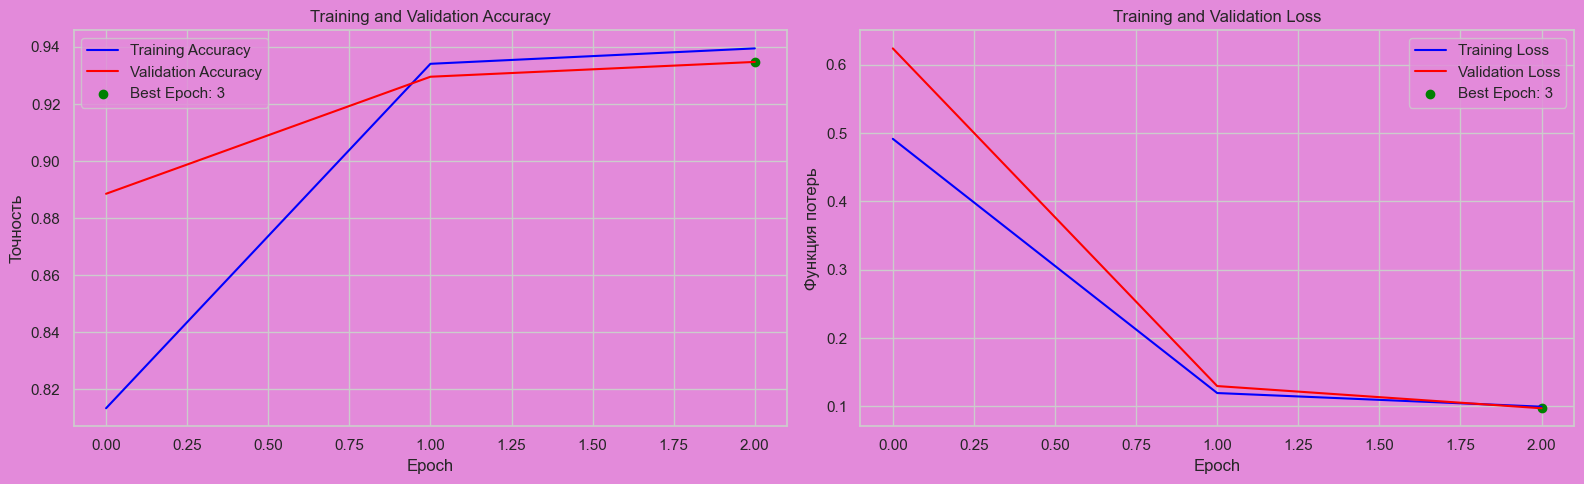

In [27]:
best_epoch = history.history['val_accuracy'].index(max(history.history['val_accuracy'])) + 1
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

axs[0].plot(history.history['accuracy'], label='Training Accuracy', color='blue')
axs[0].plot(history.history['val_accuracy'], label='Validation Accuracy', color='red')
axs[0].scatter(best_epoch - 1, history.history['val_accuracy'][best_epoch - 1], color='green', label=f'Best Epoch: {best_epoch}')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Точность')
axs[0].set_title('Training and Validation Accuracy')
axs[0].legend()

axs[1].plot(history.history['loss'], label='Training Loss', color='blue')
axs[1].plot(history.history['val_loss'], label='Validation Loss', color='red')
axs[1].scatter(best_epoch - 1, history.history['val_loss'][best_epoch - 1], color='green',label=f'Best Epoch: {best_epoch}')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Функция потерь')
axs[1].set_title('Training and Validation Loss')
axs[1].legend()

plt.tight_layout()
plt.show()

In [28]:
model.evaluate(X_test_padded, y_test)

2601/2601 ━━━━━━━━━━━━━━━━━━━━ 96s 37ms/step - accuracy: 0.9358 - loss: 0.0958


[0.09737341105937958, 0.9347671866416931]

In [29]:
from sklearn.metrics import confusion_matrix
y_pred = model.predict(X_test_padded)
y_pred = np.argmax(y_pred, axis=1)

2601/2601 ━━━━━━━━━━━━━━━━━━━━ 95s 36ms/step


<Axes: >

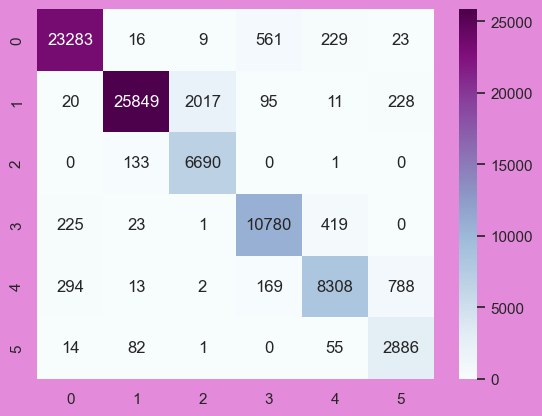

In [30]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='BuPu')

In [32]:
model1 = Sequential()

model1.add(Embedding(input_dim=input_Size, output_dim=100,input_shape=(79,)))

model1.add(Bidirectional(LSTM(128)))

model1.add(BatchNormalization())

model1.add(Dropout(0.5))

model1.add(Dense(64, activation='relu'))

model1.add(Dropout(0.5))

model1.add(Dense(6, activation='softmax'))

In [33]:
model1.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model1.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ (None, 79, 100)             │       5,000,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_3 (Bidirectional)      │ (None, 256)                 │         234,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 6)                   │             390 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,252,358 (20.04 MB)

 Trainable params: 5,251,846 (20.03 MB)

 Non-trainable params: 512 (2.00 KB)

In [36]:
history1 = model1.fit(X_train_padded, y_train, epochs=5, batch_size=32, validation_data=(X_test_padded, y_test),callbacks=[EarlyStopping(patience=3)])

Epoch 1/5
10404/10404 ━━━━━━━━━━━━━━━━━━━━ 1060s 101ms/step - accuracy: 0.8368 - loss: 0.4336 - val_accuracy: 0.9370 - val_loss: 0.1003
Epoch 2/5
10404/10404 ━━━━━━━━━━━━━━━━━━━━ 1072s 103ms/step - accuracy: 0.9369 - loss: 0.1097 - val_accuracy: 0.9393 - val_loss: 0.0958
Epoch 3/5
10404/10404 ━━━━━━━━━━━━━━━━━━━━ 1070s 103ms/step - accuracy: 0.9394 - loss: 0.1017 - val_accuracy: 0.9392 - val_loss: 0.0953
Epoch 4/5
10404/10404 ━━━━━━━━━━━━━━━━━━━━ 1068s 103ms/step - accuracy: 0.9401 - loss: 0.0976 - val_accuracy: 0.9396 - val_loss: 0.0950
Epoch 5/5
10404/10404 ━━━━━━━━━━━━━━━━━━━━ 1072s 103ms/step - accuracy: 0.9413 - loss: 0.0980 - val_accuracy: 0.9398 - val_loss: 0.0958
